<a href="https://colab.research.google.com/github/AgustinaLazzati/NLP-Project/blob/main/Deep%20Learning%20System/DL_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Fundamentals of Natural Language Processing
# Negation and Uncertainty Detection using a Deep Learning Based Approach

*Authors:*

> *Anna Blanco, Agustina Lazzati, Stanislav Bultaskii, Queralt Salvadó*

*Aims:*
> The goal of this approach is to train a single Bidirectional Long Short-Term Memory (BiLSTM) neural network using word embeddings generated by FastText. The model will be designed to perform joint detection of negation and uncertainty cues, as well as scope detection, within a unified architecture.



## Preprocessing

This part includes loading the data, merging labels, creating vocabularies, turning words and labels into numbers, getting word embeddings with FastText, and padding sequences.
Basically, it’s everything we do to prepare the text data so the model can understand and work with it.

In [1]:
# Import necessary libraries and functions
import json
import spacy
from collections import defaultdict
import re
import pandas as pd
import numpy as np
import pickle

We load the training and testing data from lstm_data.pkl file. This includes the labels for negation and uncertainty, both cue and scope.

In [2]:
with open("lstm_data.pkl", "rb") as f:
    data_dict = pickle.load(f)

lstm_train_data_neg_cue = data_dict["lstm_train_data_neg_cue"]
lstm_train_data_neg_scope = data_dict["lstm_train_data_neg_scope"]
lstm_train_data_unc_cue = data_dict["lstm_train_data_unc_cue"]
lstm_train_data_unc_scope = data_dict["lstm_train_data_unc_scope"]

lstm_test_data_neg_cue = data_dict["lstm_test_data_neg_cue"]
lstm_test_data_neg_scope = data_dict["lstm_test_data_neg_scope"]
lstm_test_data_unc_cue = data_dict["lstm_test_data_unc_cue"]
lstm_test_data_unc_scope = data_dict["lstm_test_data_unc_scope"]

print(lstm_train_data_unc_cue[10])
print(lstm_train_data_unc_scope[10])

(['la', 'uretrografia', 'miccional', 'muestra', 'una', 'uretra', 'prostatica', 'dilatada', ',', 'sin', 'claras', 'estenosis', 'focales', 'confirmandose', 'la', 'existencia', 'de', 'las', 'dos', 'estenosis', 'de', 'uretra', 'anterior', 'descritas', 'previamente', '.'], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
(['la', 'uretrografia', 'miccional', 'muestra', 'una', 'uretra', 'prostatica', 'dilatada', ',', 'sin', 'claras', 'estenosis', 'focales', 'confirmandose', 'la', 'existencia', 'de', 'las', 'dos', 'estenosis', 'de', 'uretra', 'anterior', 'descritas', 'previamente', '.'], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


We combine the four label types into a single label per word. This makes it easier to train one model instead of four.

In [3]:
def merge_all_labels(
    neg_cues, neg_scopes,
    unc_cues, unc_scopes,
    neg_cue_prefix="NEG", neg_scope_prefix="NSCO",
    unc_cue_prefix="UNC", unc_scope_prefix="UNSCO"
):
    merged = []
    for nc, ns, uc, us in zip(neg_cues, neg_scopes, unc_cues, unc_scopes):
        labels = []
        if nc != 0:
            labels.append(f"{neg_cue_prefix}")
        if ns != 0:
            labels.append(f"{neg_scope_prefix}")
        if uc != 0:
            labels.append(f"{unc_cue_prefix}")
        if us != 0:
            labels.append(f"{unc_scope_prefix}")

        merged_label = "+".join(labels) if labels else "0"

        # Handle unwanted combinations
        if merged_label == "NEG+NSCO":
            merged_label = "NEG"
        elif merged_label in {
            "NEG+UNSCO",
            "NSCO+UNSCO",
            "UNC+UNSCO"
        }:
            merged_label = "0"

        merged.append(merged_label)
    return merged

We match each sentence with its combined labels so we can use them as training and test examples.

In [4]:
# Merge all data: negation + uncertainty
lstm_train_data_all = [
    (tokens, merge_all_labels(neg_cue_labels, neg_scope_labels, unc_cue_labels, unc_scope_labels))
    for ((tokens, neg_cue_labels), (_, neg_scope_labels),
          (_, unc_cue_labels), (_, unc_scope_labels)) in zip(
        lstm_train_data_neg_cue,
        lstm_train_data_neg_scope,
        lstm_train_data_unc_cue,
        lstm_train_data_unc_scope
    )
]

lstm_test_data_all = [
    (tokens, merge_all_labels(neg_cue_labels, neg_scope_labels, unc_cue_labels, unc_scope_labels))
    for ((tokens, neg_cue_labels), (_, neg_scope_labels),
          (_, unc_cue_labels), (_, unc_scope_labels)) in zip(
        lstm_test_data_neg_cue,
        lstm_test_data_neg_scope,
        lstm_test_data_unc_cue,
        lstm_test_data_unc_scope
    )
]

print(lstm_train_data_all[3])
print(lstm_train_data_all[10])

(['no', 'habitos', 'toxicos', '.'], ['NEG', 'NSCO', 'NSCO', 'NSCO'])
(['la', 'uretrografia', 'miccional', 'muestra', 'una', 'uretra', 'prostatica', 'dilatada', ',', 'sin', 'claras', 'estenosis', 'focales', 'confirmandose', 'la', 'existencia', 'de', 'las', 'dos', 'estenosis', 'de', 'uretra', 'anterior', 'descritas', 'previamente', '.'], ['0', '0', '0', '0', '0', '0', '0', '0', '0', 'UNC', 'UNC', 'UNSCO', 'UNSCO', 'UNSCO', 'UNSCO', 'UNSCO', 'UNSCO', 'UNSCO', 'UNSCO', 'UNSCO', 'UNSCO', 'UNSCO', 'UNSCO', 'UNSCO', 'UNSCO', 'UNSCO'])


We download the pre-trained FastText model that turns each word into a 300-dimensional vector.


FastText is a word embedding model from Facebook that represents words using subword information (like character n-grams), so it understands rare and misspelled words better than models like Word2Vec.
We use FastText because it helps the neural network understand the meaning of words, even if they weren’t in the training data.

In [5]:
!pip install fasttext

import fasttext

# Download the English fastText model
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
# Unzip the downloaded file
!gunzip cc.en.300.bin.gz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 7.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313505 sha256=6127d6c4137f8772acded8fbb77872cb735d85caa2ddbca95b6220816402d62c
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext
--2025-05-28 08:55:27--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.102, 108.157.254.15, 108.157.254.124, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length

In [6]:
# Load pretrained FastText model (English, 300-dimensional vectors)
fasttext_model = fasttext.load_model("cc.en.300.bin")

We create mappings to turn each word and label into a number. This is necessary because the model works with numbers, not text.

In [7]:
from collections import defaultdict

def build_vocab(sentences):
    word2idx = defaultdict(lambda: 0)
    idx = 1
    for sent in sentences:
        for word in sent:
            if word not in word2idx:
                word2idx[word] = idx
                idx += 1
    return dict(word2idx)

def build_label_vocab(labels_list):
    label_set = set()
    for labels in labels_list:
        label_set.update(labels)
    label2idx = {label: i for i, label in enumerate(sorted(label_set))}
    return label2idx

# Extract from merged all-data version
all_train_sentences_all = [x[0] for x in lstm_train_data_all]
all_train_labels_all = [x[1] for x in lstm_train_data_all]

all_test_sentences_all = [x[0] for x in lstm_test_data_all]
all_test_labels_all = [x[1] for x in lstm_test_data_all]

# Merge train + test for vocab building
all_sentences = all_train_sentences_all + all_test_sentences_all
all_labels = all_train_labels_all + all_test_labels_all

# Build vocabularies
word2idx = build_vocab(all_sentences)
label2idx = build_label_vocab(all_labels)

# Output info
print(f"Vocabulary size (words): {len(word2idx)}")
print(f"Number of unique labels: {len(label2idx)}")

# Example mappings
print(f"Example word2idx: {list(word2idx.items())[:10]}")
print(f"Example label2idx: {list(label2idx.items())[:10]}")

Vocabulary size (words): 23359
Number of unique labels: 5
Example word2idx: [(' ', 1), ('nº', 2), ('historia', 3), ('clinica', 4), (':', 5), ('*', 6), ('nºepisodi', 7), ('sexe', 8), ('home', 9), ('data', 10)]
Example label2idx: [('0', 0), ('NEG', 1), ('NSCO', 2), ('UNC', 3), ('UNSCO', 4)]


We build a matrix where each row is a word vector from FastText. If a word is missing, we add a random vector.

In [8]:
import numpy as np

vocab_size = len(word2idx) + 1  # +1 for padding idx=0
embedding_matrix = np.zeros((vocab_size, 300))

for word, idx in word2idx.items():
    try:
        embedding_vector = fasttext_model.get_word_vector(word)
        embedding_matrix[idx] = embedding_vector
    except KeyError:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(300,))

We change all sentences and labels into sequences of integers using the vocab dictionaries.

In [9]:
def encode_sentences(sentences, word2idx):
    return [[word2idx.get(word, 0) for word in sent] for sent in sentences]

def encode_labels(labels, label2idx):
    return [[label2idx[str(label)] for label in lab_seq] for lab_seq in labels]

# Combined (negation + uncertainty)
X_train_all = encode_sentences(all_train_sentences_all, word2idx)
y_train_all = encode_labels(all_train_labels_all, label2idx)

X_test_all = encode_sentences(all_test_sentences_all, word2idx)
y_test_all = encode_labels(all_test_labels_all, label2idx)

print("Example input (token indices):", X_train_all[10])
print("Example labels (label indices):", y_train_all[10])

Example input (token indices): [111, 129, 158, 130, 131, 98, 159, 160, 30, 105, 161, 97, 134, 162, 111, 112, 11, 163, 133, 97, 11, 98, 132, 164, 165, 44]
Example labels (label indices): [0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


We make all input and label sequences the same length by adding padding. This is needed to batch them together.

In [10]:
from torch.nn.utils.rnn import pad_sequence
import torch

def pad_sequences(sequences, pad_value=0):
    tensor_seqs = [torch.tensor(seq) for seq in sequences]
    padded_seqs = pad_sequence(tensor_seqs, batch_first=True, padding_value=pad_value)
    return padded_seqs

# Pad inputs and labels (combined negation + uncertainty)
X_train_all_padded = pad_sequences(X_train_all, pad_value=0)
y_train_all_padded = pad_sequences(y_train_all, pad_value=label2idx.get('0', 0))

X_test_all_padded = pad_sequences(X_test_all, pad_value=0)
y_test_all_padded = pad_sequences(y_test_all, pad_value=label2idx.get('0', 0))

print("X_train shape:", X_train_all_padded.shape)
print("y_train shape:", y_train_all_padded.shape)

X_train shape: torch.Size([12733, 513])
y_train shape: torch.Size([12733, 513])


We prepare the data for PyTorch by creating dataset objects and data loaders. These let us feed the model in small batches.

In [11]:
from torch.utils.data import Dataset, DataLoader

class SequenceTaggingDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create dataset objects
train_dataset = SequenceTaggingDataset(X_train_all_padded, y_train_all_padded)
test_dataset = SequenceTaggingDataset(X_test_all_padded, y_test_all_padded)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## BiLSTM Model

We create a deep learning model that uses LSTM and GRU layers to understand the meaning of words in a sentence.


BiLSTM stands for "Bidirectional Long Short-Term Memory", it reads the sentence from left to right and also from right to left, which helps the model understand the full context of each word.


This is a good choice for our task because meaning often depends on the words before and after a word (especially for things like negation and uncertainty).

In [12]:
import torch.nn as nn
import torch

class BiLSTM(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim_lstm, hidden_dim_gru, output_dim, pad_idx=0):
        super(BiLSTM, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  # freeze embeddings

        self.lstm = nn.LSTM(embedding_dim, hidden_dim_lstm, batch_first=True, bidirectional=True)
        self.gru = nn.GRU(hidden_dim_lstm * 2, hidden_dim_gru, batch_first=True, bidirectional=True)

        self.fc = nn.Linear(hidden_dim_gru * 2, output_dim)  # times 2 for bidirectional GRU output

    def forward(self, x):
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)

        lstm_out, _ = self.lstm(embedded)  # (batch_size, seq_len, hidden_dim_lstm*2)
        gru_out, _ = self.gru(lstm_out)    # (batch_size, seq_len, hidden_dim_gru*2)

        logits = self.fc(gru_out)  # (batch_size, seq_len, output_dim)
        return logits

We calculate weights for each label so the model doesn’t ignore rare tags like uncertainty cues.

In [13]:
import numpy as np
from collections import Counter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Flatten tensor to 1D and move to CPU numpy array
all_train_labels = y_train_all_padded.view(-1).cpu().numpy()

# Count occurrences of each label
label_counts = Counter(all_train_labels)

total_count = sum(label_counts.values())
class_weights = {label: total_count/count for label, count in label_counts.items()}

# Convert to a tensor ordered by label index
num_classes = len(label_counts)
weights = torch.zeros(num_classes)
for label, weight in class_weights.items():
    weights[label] = weight

weights = weights.to(device)

In [14]:
import torch
import torch.optim as optim
import torch.nn as nn

hidden_dim_lstm = 128
hidden_dim_gru = 64
output_dim = len(label2idx)
pad_idx = 0

# Instantiate model
model = BiLSTM(embedding_matrix, hidden_dim_lstm, hidden_dim_gru, output_dim, pad_idx)

# Move to GPU if available
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(weight=weights, ignore_index=pad_idx)
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Training the model

In [15]:
from torch.utils.data import DataLoader, TensorDataset

def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for batch in dataloader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)  # outputs shape: (batch_size, seq_len, output_dim)

        # Reshape for loss: combine batch and seq dims
        outputs = outputs.view(-1, outputs.shape[-1])  # (batch_size * seq_len, output_dim)
        labels = labels.view(-1)                       # (batch_size * seq_len)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

Epoch 1/5 - Loss: 0.6113
Epoch 2/5 - Loss: 0.3196
Epoch 3/5 - Loss: 0.2123
Epoch 4/5 - Loss: 0.1313
Epoch 5/5 - Loss: 0.1043


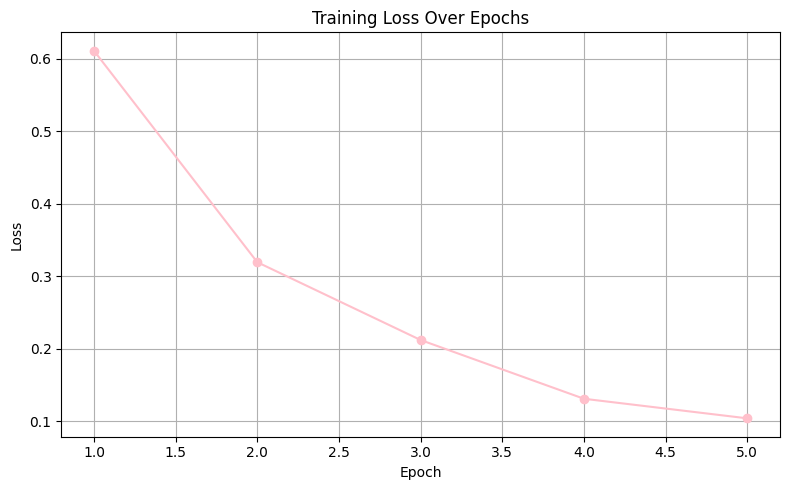

In [16]:
import matplotlib.pyplot as plt

num_epochs = 5
train_losses = []

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f}")

# Plot the training loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='pink')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

We test the model on unseen data. We compare its predictions to the correct labels (ignoring padding).

In [47]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

idx2label = {v: k for k,v in label2idx.items()}

pad_label_id = label2idx["0"]

model.eval()
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        predictions = torch.argmax(outputs, dim=-1)

        for i in range(labels.size(0)):
            for j in range(labels.size(1)):
                if labels[i][j].item() != pad_label_id:
                    true_label = idx2label[labels[i][j].item()]
                    pred_label = idx2label[predictions[i][j].item()]
                    all_labels.append(true_label)
                    all_preds.append(pred_label)

print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

         NEG     0.9857    0.9744    0.9800      1132
        NSCO     0.9876    0.9752    0.9814      3592
         UNC     0.7333    0.8844    0.8018       199
       UNSCO     0.8834    0.9099    0.8964       566

    accuracy                         0.9650      5489
   macro avg     0.8975    0.9360    0.9149      5489
weighted avg     0.9672    0.9650    0.9658      5489



The model performs very well overall, especially on negation, with slightly lower scores on uncertainty, showing strong accuracy in detecting both cue and scope.


# Visualizing our results
Again, as in Rule-based system and ML aproach, we constructed the **confusion matrix** of our model (overall and per-label performance).


In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred):
    """
    Plots a confusion matrix to visualize the performance of the model at the token level.

    Parameters:
    - y_true: List of true labels for each token in the dataset.
    - y_pred: List of predicted labels for each token in the dataset.

    Returns:
    - A heatmap visualization of the confusion matrix.
    """
    # Get sorted list of all labels
    labels = sorted(list(set(y_true + y_pred)))

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize=None)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="RdPu", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix (Token-Level)")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def plot_per_attribute_confusion_matrices(y_true, y_pred, relevant_labels):
    """
    For each attribute, compute and plot a 2x2 confusion matrix (TP, FP, FN, TN)
    based on presence/absence of the attribute in the predictions.
    Only words with relevant labels in y_true or y_pred will be considered.
    All confusion matrices will be displayed in one grid.
    """
    # Filter out words without relevant labels in either y_true or y_pred
    filtered_y_true = []
    filtered_y_pred = []

    # Go through each pair of sequences in y_true and y_pred
    for true_seq, pred_seq in zip(y_true, y_pred):
        for (true_word, true_label), (pred_word, pred_label) in zip(true_seq, pred_seq):
            # Only consider words that have relevant labels in either true or predicted labels
            if true_label in relevant_labels or pred_label in relevant_labels:
                filtered_y_true.append(true_label)
                filtered_y_pred.append(pred_label)

    # If the filtered lists are empty, exit the function
    if not filtered_y_true or not filtered_y_pred:
        print("No relevant labels found in the data.")
        return

    num_labels = len(relevant_labels)
    grid_size = (num_labels // 2, 2) if num_labels % 2 == 0 else (num_labels // 2 + 1, 2)

    # Create subplots
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(10, 8))
    axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

    # Compute and plot confusion matrix for each relevant label
    for i, label in enumerate(relevant_labels):
        binary_true = [1 if true_label == label else 0 for true_label in filtered_y_true]
        binary_pred = [1 if pred_label == label else 0 for pred_label in filtered_y_pred]

        # Compute confusion matrix: TN, FP, FN, TP
        cm = confusion_matrix(binary_true, binary_pred, labels=[0, 1])
        tn, fp, fn, tp = cm.ravel()

        # Plot confusion matrix on the corresponding axis
        sns.heatmap(cm, annot=True, fmt="d", cmap="RdPu", xticklabels=["Not " + label, label],
                    yticklabels=["Not " + label, label], ax=axes[i])
        axes[i].set_title(f"Confusion Matrix for {label}")
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("Actual")
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].tick_params(axis='y', rotation=0)

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()



Confusion Matrix (Token-Level):


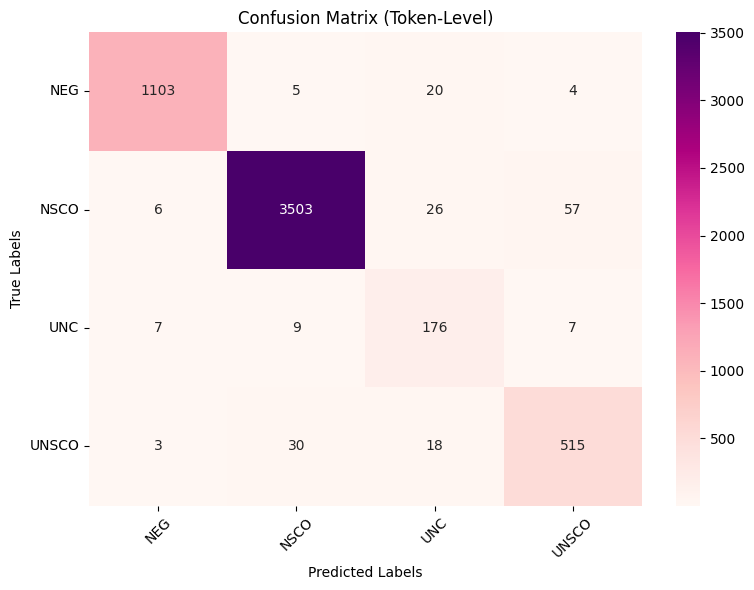


 Confusion Matrix per-label:


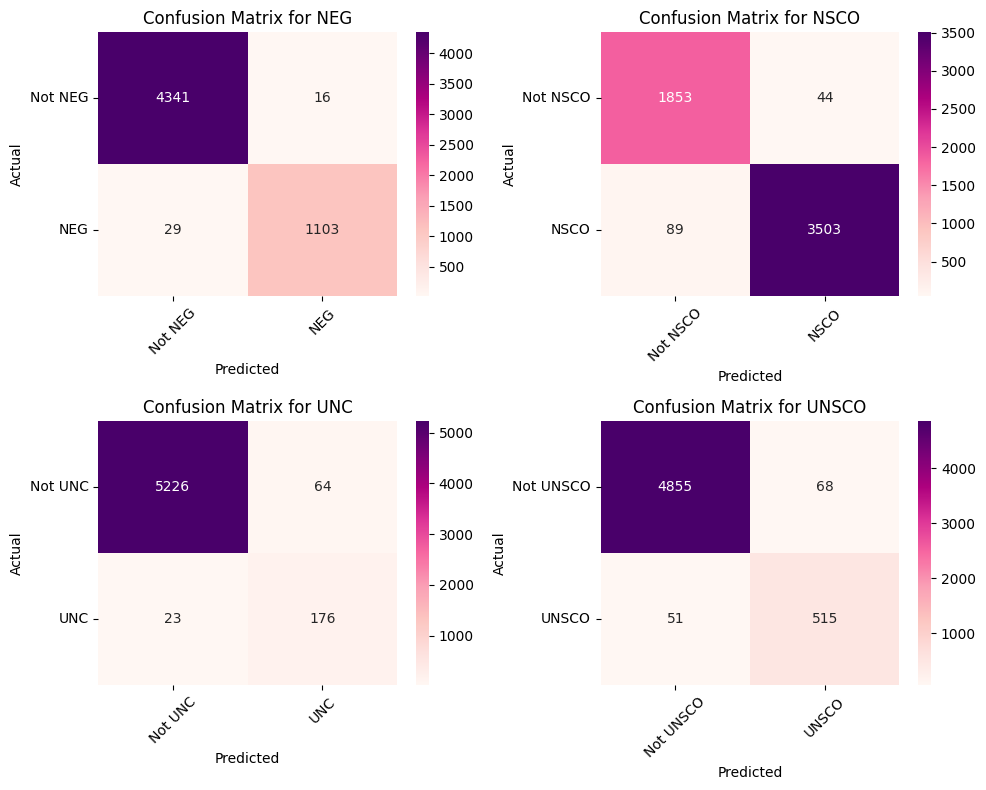

In [22]:
print("Confusion Matrix (Token-Level):")
plot_confusion_matrix(all_labels, all_preds)

print("\n Confusion Matrix per-label:")
# Convert single label pairs into expected (word, label) format
y_true_seq = [[("token", label)] for label in all_labels]
y_pred_seq = [[("token", label)] for label in all_preds]

relevant_labels = ["NEG", "NSCO", "UNC", "UNSCO"]  # adjust based on your label set
plot_per_attribute_confusion_matrices(y_true_seq, y_pred_seq, relevant_labels)